In [ ]:
# Step 0: Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split, TimeSeriesSplit
import xgboost as xgb
from statsmodels.tsa.holtwinters import ExponentialSmoothing

In [ ]:
# Step 1: Load data
features = pd.read_csv("features.csv")
sales = pd.read_csv("train.csv")
stores = pd.read_csv("stores.csv")

In [ ]:
# Merge datasets
data = sales.merge(features, on=['Store', 'Date', 'IsHoliday'], how='left')
data = data.merge(stores, on='Store', how='left')

# Convert to datetime
data['Date'] = pd.to_datetime(data['Date'])

# Sort by Store and Date
data = data.sort_values(by=['Store', 'Dept', 'Date'])

In [ ]:
# Step 2: Feature engineering
data['Year'] = data['Date'].dt.year
data['Month'] = data['Date'].dt.month
data['Week'] = data['Date'].dt.isocalendar().week.astype(int)
data['Day'] = data['Date'].dt.dayofweek

# Lag features
data['Lag_1'] = data.groupby(['Store', 'Dept'])['Weekly_Sales'].shift(1)
data['Lag_52'] = data.groupby(['Store', 'Dept'])['Weekly_Sales'].shift(52)
data['Rolling_Mean_4'] = data.groupby(['Store', 'Dept'])['Weekly_Sales'].transform(lambda x: x.shift(1).rolling(4).mean())

# Fill NA
data.fillna(0, inplace=True)

# Encode categorical
data['IsHoliday'] = data['IsHoliday'].astype(int)
data = pd.get_dummies(data, columns=['Type'], drop_first=True)

In [ ]:
# Step 3: Metric function - Weighted MAE
def WMAE(y_true, y_pred, weights):
    return np.round(np.sum(weights * np.abs(y_true - y_pred)) / np.sum(weights), 2)

In [ ]:
# Step 4: Define features and target BEFORE using TimeSeriesSplit
feature_cols = ['Store', 'Dept', 'Year', 'Month', 'Week', 'Day',
                'Temperature', 'Fuel_Price', 'CPI', 'Unemployment',
                'IsHoliday', 'Lag_1', 'Lag_52', 'Rolling_Mean_4',
                'Type_B', 'Type_C']

X = data[feature_cols]
y = data['Weekly_Sales']
weights = data['IsHoliday'].apply(lambda x: 5 if x == 1 else 1)


In [ ]:
# Time-aware validation using TimeSeriesSplit
from sklearn.model_selection import TimeSeriesSplit

tscv = TimeSeriesSplit(n_splits=5)
rf_wmae_scores = []

for fold, (train_index, test_index) in enumerate(tscv.split(X)):
    print(f"Fold {fold+1}")

    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    w_train, w_test = weights.iloc[train_index], weights.iloc[test_index]

    model_rf = RandomForestRegressor(n_estimators=100, random_state=42)
    model_rf.fit(X_train, y_train)

    pred_rf = model_rf.predict(X_test)
    wmae = WMAE(y_test, pred_rf, w_test)
    rf_wmae_scores.append(wmae)

    print(f"WMAE for fold {fold+1}: {wmae}")

print("\nAverage WMAE across folds:", np.mean(rf_wmae_scores))

Fold 1
WMAE for fold 1: 2703.55
Fold 2
WMAE for fold 2: 2156.53
Fold 3
WMAE for fold 3: 2297.09
Fold 4
WMAE for fold 4: 1582.88
Fold 5
WMAE for fold 5: 1456.64

Average WMAE across folds: 2039.3379999999997


In [ ]:
# Step 5: XGBoost (bonus)
model_xgb = xgb.XGBRegressor(n_estimators=100, learning_rate=0.1, random_state=42)
model_xgb.fit(X_train, y_train)
pred_xgb = model_xgb.predict(X_test)
print("XGBoost WMAE:", WMAE(y_test, pred_xgb, w_test))

XGBoost WMAE: 1498.23


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-FRI will be used.
  self._init_dates(dates, freq)


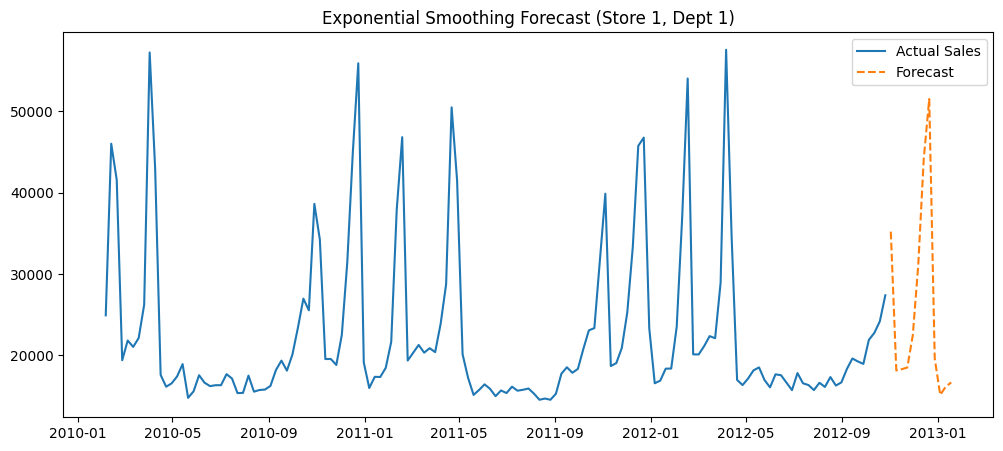

In [ ]:
# Step 6: Time series model - Exponential Smoothing (one store-dept example)
sample_df = data[(data['Store'] == 1) & (data['Dept'] == 1)].copy()
sample_df.set_index('Date', inplace=True)

model_exp = ExponentialSmoothing(sample_df['Weekly_Sales'], seasonal='add', seasonal_periods=52)
fit_exp = model_exp.fit()
forecast = fit_exp.forecast(12)

# Plot forecast
plt.figure(figsize=(12,5))
plt.plot(sample_df['Weekly_Sales'], label="Actual Sales")
plt.plot(forecast, label="Forecast", linestyle="--")
plt.title("Exponential Smoothing Forecast (Store 1, Dept 1)")
plt.legend()
plt.show()

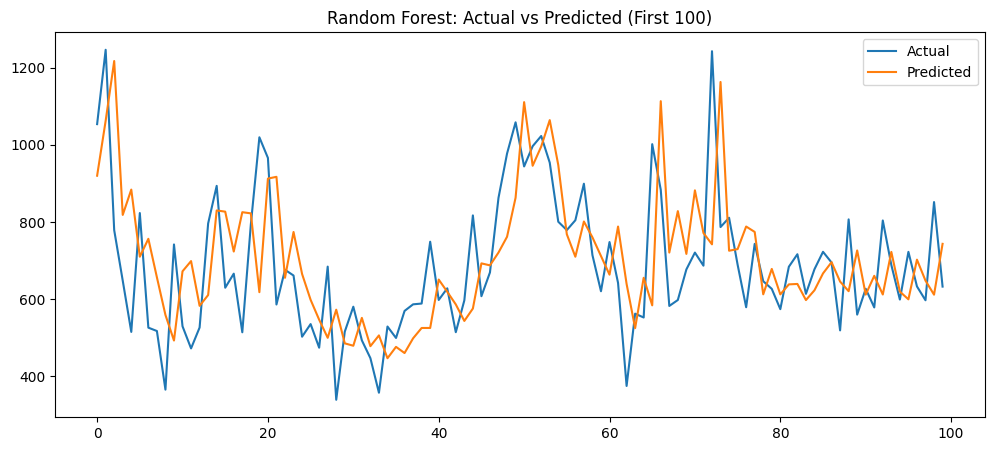

In [ ]:
# Step 7: Actual vs Predicted (Random Forest)
plt.figure(figsize=(12,5))
plt.plot(y_test.values[:100], label='Actual')
plt.plot(pred_rf[:100], label='Predicted')
plt.title('Random Forest: Actual vs Predicted (First 100)')
plt.legend()
plt.show()